In [1]:
import pandas as pd
import os
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
df_sample = pd.read_parquet("../../datasets/3W/dataset/0/WELL-00001_20170201010207.parquet")
df_sample.columns

Index(['ABER-CKGL', 'ABER-CKP', 'ESTADO-DHSV', 'ESTADO-M1', 'ESTADO-M2',
       'ESTADO-PXO', 'ESTADO-SDV-GL', 'ESTADO-SDV-P', 'ESTADO-W1', 'ESTADO-W2',
       'ESTADO-XO', 'P-ANULAR', 'P-JUS-BS', 'P-JUS-CKGL', 'P-JUS-CKP',
       'P-MON-CKGL', 'P-MON-CKP', 'P-MON-SDV-P', 'P-PDG', 'PT-P', 'P-TPT',
       'QBS', 'QGL', 'T-JUS-CKP', 'T-MON-CKP', 'T-PDG', 'T-TPT', 'class',
       'state'],
      dtype='object')

In [3]:
recap_column = ['instance','name','start_time','end_time']+list(df_sample.columns)
recap_df = pd.DataFrame(columns=recap_column)

dataset_dir = "../../datasets/3W/dataset"

count = 0


In [4]:


# for folder in os.listdir(dataset_dir):
#     folder_path = os.path.join(dataset_dir, folder)
#     if os.path.isdir(folder_path):
#         # print(folder)
#         for files in os.listdir(folder_path):
#             recap_row = pd.DataFrame(columns=recap_column)
#             file_path = os.path.join(folder_path, files)
#             df = pd.read_parquet(file_path)
#             df.dropna(subset='class',inplace=True)
#             # print(files)
#             recap_row.loc[0, 'start_time'] = df.index[0]
#             recap_row.loc[0, 'end_time'] = df.index[-1]

#             recap_row.loc[0, 'instance'] = folder
#             recap_row.loc[0, 'name'] = files

#             for column in df.columns:
#                 if column == 'class':
#                     recap_row.loc[0, column] = 1
#                 else:
#                     # Check for missing values or frozen values
#                     if df[column].isna().any() or df[column].nunique() == 1:
#                         recap_row.loc[0, column] = 0  # Mark as 0 if missing or frozen
#                     else:
#                         recap_row.loc[0, column] = 1  # Mark as 1 otherwise
            
#             # Append the row to recap_df
#             recap_df = pd.concat([recap_df, recap_row], ignore_index=True)

In [5]:
def remove_outliers_iqr(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for each column
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define the bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to remove outliers
    for column in df.columns[:-1]:  # Exclude 'class' from outlier removal
        df = df[(df[column] >= lower_bound[column]) & (df[column] <= upper_bound[column])]
    
    return df

In [7]:
filtered_dataset = "../../filtered_dataset"
name_file_path = '../../filtered_dataset/name/0.txt'

# Initialize an empty list to store the lines
instance_0_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    instance_0_list_files = [line.strip() for line in file.readlines()]

columns_selected = ['T-TPT', 'P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']
selected_instance_0_df = pd.DataFrame(columns=columns_selected)

# Load each file and concatenate the selected columns
for instance_file_0 in instance_0_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_0))
    df = df[columns_selected]
    df['class'].fillna(value=0, inplace=True)
    selected_instance_0_df = pd.concat([selected_instance_0_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in selected_instance_0_df.columns if col.startswith('P')]
selected_instance_0_df[pressure_columns] = selected_instance_0_df[pressure_columns] / 10**6

# Standard scaling for the other columns (excluding 'class')
scaler = StandardScaler()
scaler.fit(selected_instance_0_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-0-filtered.pkl', 'wb'))

# Apply outlier removal (if required)
selected_instance_0_df = remove_outliers_iqr(selected_instance_0_df)
print(selected_instance_0_df.values.shape)
# Save the final DataFrame to a CSV file
selected_instance_0_df.to_csv("../../filtered_dataset/train/selected_instance_0.csv", index_label='timestamp')

/tmp/ipykernel_53699/695187764.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_0_df = pd.concat([selected_instance_0_df, df])
/tmp/ipykernel_53699/695187764.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_0_df = pd.concat([selected_instance_0_df, df])


(239985, 6)


In [15]:
selected_instance_0_df.quantile(0.25)

T-TPT          118.5345
P-TPT        18063260.0
P-MON-CKP     2490287.0
T-JUS-CKP      79.49731
P-PDG        44858050.0
class               0.0
Name: 0.25, dtype: Float64

<Axes: >

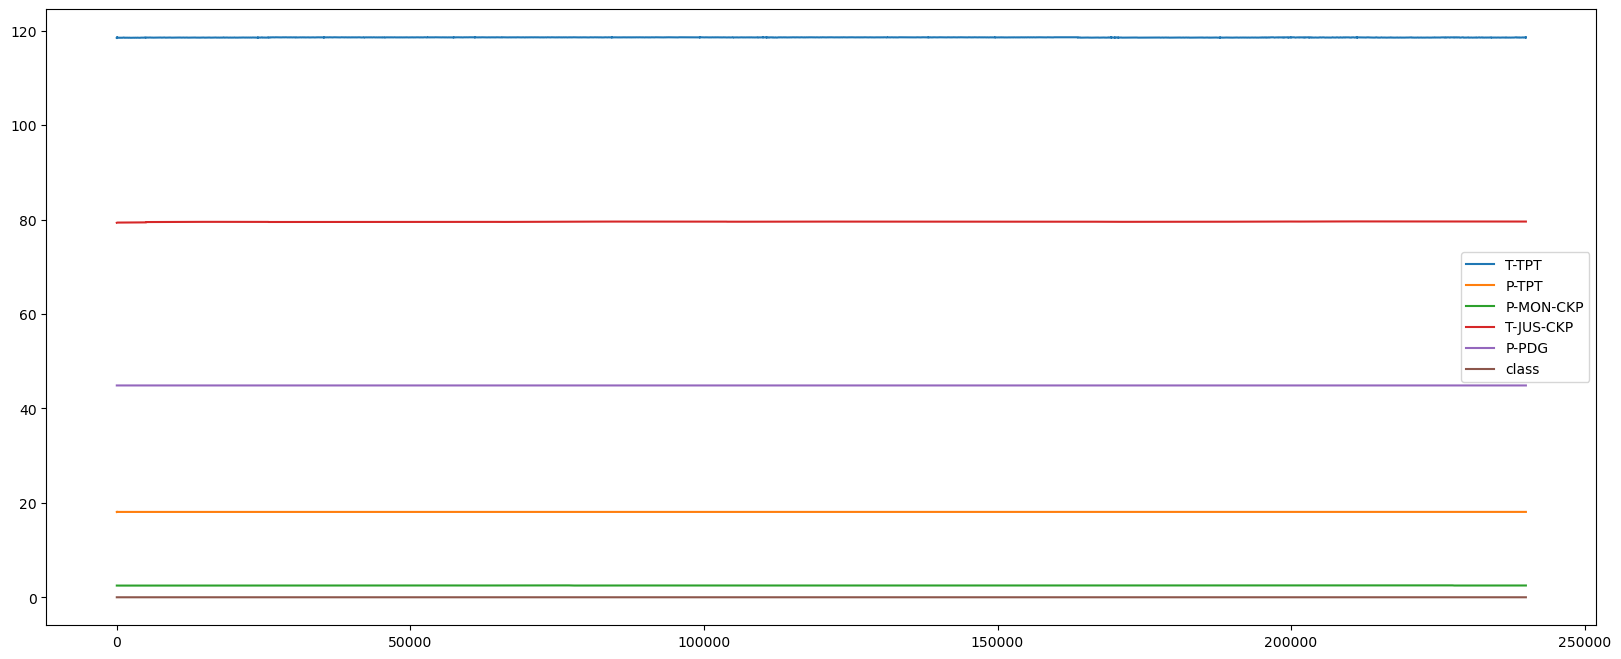

In [18]:
selected_instance_0_df.reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))

In [8]:
filtered_dataset =  "../../filtered_dataset"
filtered_train_dataset =  os.path.join(filtered_dataset, "train")

columns_selected = ['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']

name_file_path = '../../filtered_dataset/name/2.txt' 

# Initialize an empty list to store the lines
instance_2_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    # Read each line and strip any leading/trailing whitespace
    instance_2_list_files = [line.strip() for line in file.readlines()]

selected_instance_2_df = pd.DataFrame(columns=columns_selected)
for instance_file_2 in instance_2_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_2))
    df = df[columns_selected]
    df['class'].fillna(value=0, inplace=True)  # Remove rows where 'class' is NaN
    df = df[df['class'] == 0]
    selected_instance_2_df = pd.concat([selected_instance_2_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in selected_instance_2_df.columns if col.startswith('P')]
selected_instance_2_df[pressure_columns] = selected_instance_2_df[pressure_columns] / 10**6

scaler = StandardScaler()
scaler.fit(selected_instance_2_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-2-filtered.pkl', 'wb'))

selected_instance_2_df = remove_outliers_iqr(selected_instance_2_df)
print(selected_instance_2_df.shape)
selected_instance_2_df.to_csv("../../filtered_dataset/train/selected_instance_2.csv", index_label='timestamp')

(28800, 6)


/tmp/ipykernel_53699/2812381420.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_2_df = pd.concat([selected_instance_2_df, df])
/tmp/ipykernel_53699/2812381420.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_2_df = pd.concat([selected_instance_2_df, df])


<Axes: >

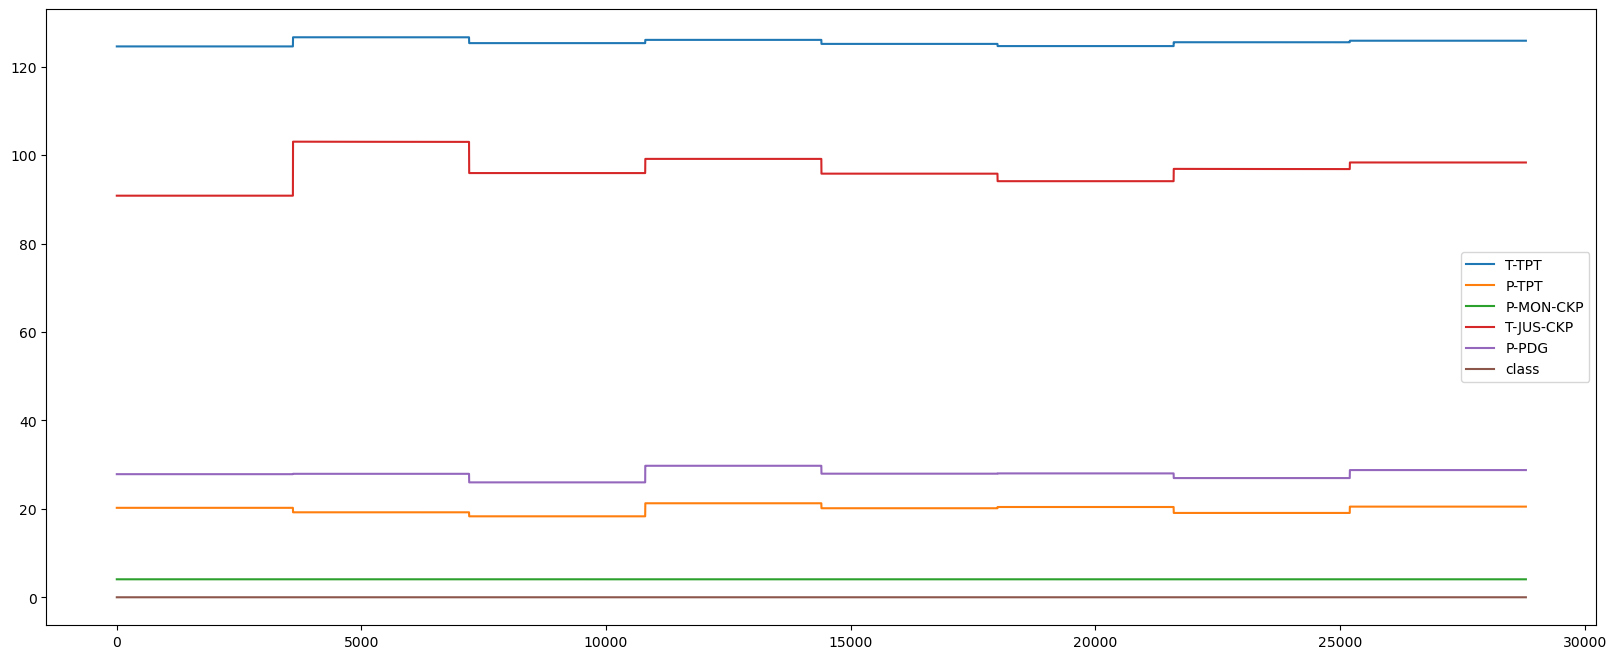

In [20]:
selected_instance_2_df.reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))

In [21]:
filtered_dataset =  "../../filtered_dataset"
filtered_train_dataset =  os.path.join(filtered_dataset, "train")

name_file_path = '../../filtered_dataset/name/4.txt' 

# Initialize an empty list to store the lines
instance_4_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    # Read each line and strip any leading/trailing whitespace
    instance_4_list_files = [line.strip() for line in file.readlines()]

columns_selected = ['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']

selected_instance_4_df = pd.DataFrame(columns=columns_selected)
for instance_file_4 in instance_4_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_4))
    df = df[columns_selected]
    df['class'].fillna(value=0, inplace=True)  # Remove rows where 'class' is NaN
    df = df[df['class'] == 0]
    selected_instance_4_df = pd.concat([selected_instance_4_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in selected_instance_4_df.columns if col.startswith('P')]
selected_instance_4_df[pressure_columns] = selected_instance_4_df[pressure_columns] / 10**6    

scaler = StandardScaler()
scaler.fit(selected_instance_4_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-4-filtered.pkl', 'wb'))

selected_instance_4_df = remove_outliers_iqr(selected_instance_4_df)
selected_instance_4_df.to_csv("../../filtered_dataset/train/selected_instance_4.csv", index_label='timestamp')

/tmp/ipykernel_185818/458974289.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_4_df = pd.concat([selected_instance_4_df, df])
/tmp/ipykernel_185818/458974289.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_4_df = pd.concat([selected_instance_4_df, df])


<Axes: >

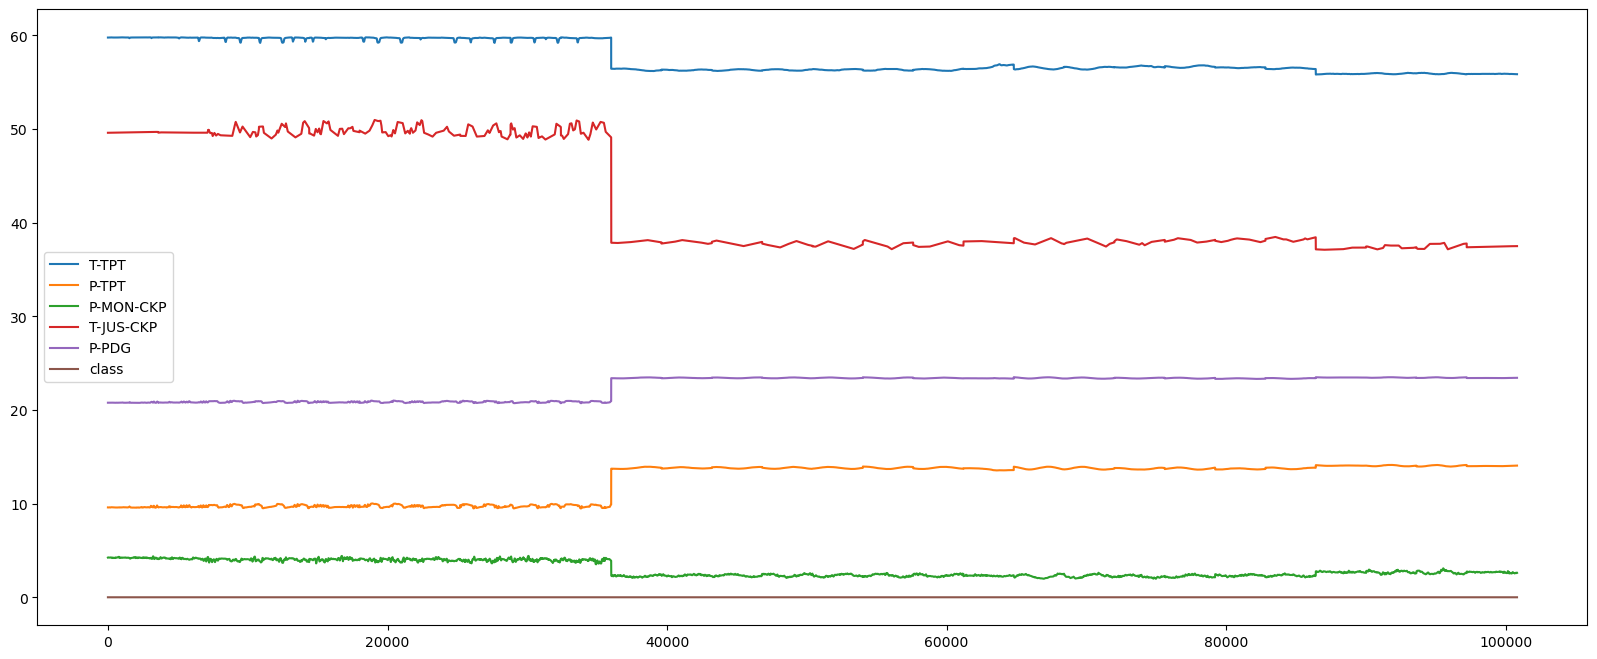

In [22]:
selected_instance_4_df.reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))

In [9]:
filtered_dataset =  "../../filtered_dataset"
filtered_train_dataset =  os.path.join(filtered_dataset, "train")

columns_selected = ['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']

name_file_path = '../../filtered_dataset/name/5.txt' 

# Initialize an empty list to store the lines
instance_5_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    # Read each line and strip any leading/trailing whitespace
    instance_5_list_files = [line.strip() for line in file.readlines()]

selected_instance_5_df = pd.DataFrame(columns=columns_selected)
for instance_file_5 in instance_5_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_5))
    df = df[columns_selected]
    # df['class'].fillna(value=0, inplace=True)  # Remove rows where 'class' is NaN
    df = df[df['class'] == 0]
    selected_instance_5_df = pd.concat([selected_instance_5_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in selected_instance_5_df.columns if col.startswith('P')]
selected_instance_5_df[pressure_columns] = selected_instance_5_df[pressure_columns] / 10**6


scaler = StandardScaler()
scaler.fit(selected_instance_5_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-5-filtered.pkl', 'wb'))

selected_instance_5_df = remove_outliers_iqr(selected_instance_5_df)
print(selected_instance_5_df.shape)
selected_instance_5_df.to_csv("../../filtered_dataset/train/selected_instance_5.csv", index_label='timestamp')

/tmp/ipykernel_53699/1042525521.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_5_df = pd.concat([selected_instance_5_df, df])
/tmp/ipykernel_53699/1042525521.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_5_df = pd.concat([selected_instance_5_df, df])


(154500, 6)


<Axes: >

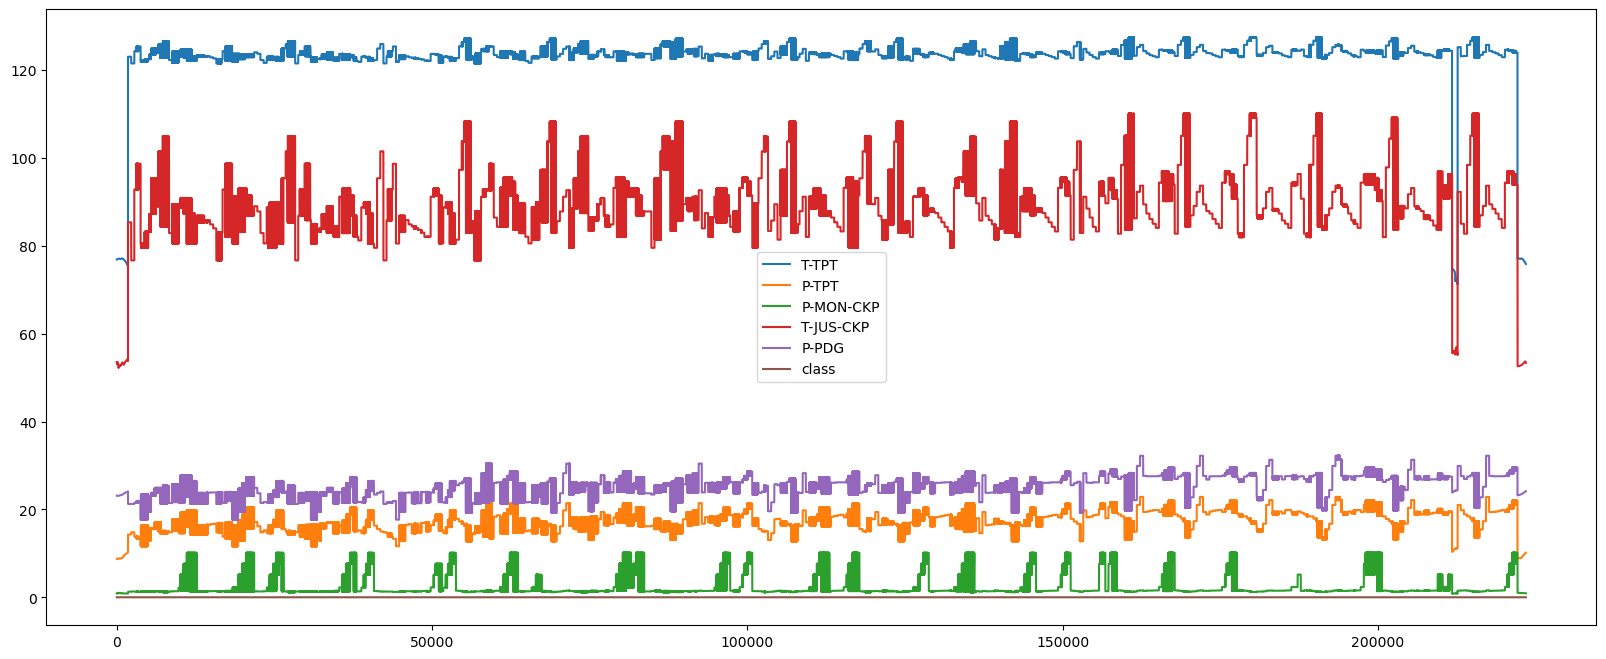

In [7]:
selected_instance_5_df.sort_index().reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))

In [13]:
filtered_dataset =  "../../filtered_dataset"
filtered_train_dataset =  os.path.join(filtered_dataset, "train")

columns_selected = ['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']

name_file_path = '../../filtered_dataset/name/7.txt' 

# Initialize an empty list to store the lines
instance_7_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    # Read each line and strip any leading/trailing whitespace
    instance_7_list_files = [line.strip() for line in file.readlines()]

selected_instance_7_df = pd.DataFrame(columns=columns_selected)
for instance_file_7 in instance_7_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_7))
    df = df[columns_selected]
    df['class'].fillna(value=0, inplace=True)  # Remove rows where 'class' is NaN
    df = df[df['class'] == 0]
    selected_instance_7_df = pd.concat([selected_instance_7_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
# pressure_columns = [col for col in selected_instance_7_df.columns if col.startswith('P')]
# selected_instance_7_df[pressure_columns] = selected_instance_7_df[pressure_columns] / 10**6

scaler = StandardScaler()
scaler.fit(selected_instance_7_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-7-filtered.pkl', 'wb'))

selected_instance_7_df = remove_outliers_iqr(selected_instance_7_df)
selected_instance_7_df.to_csv("../../filtered_dataset/train/selected_instance_7.csv", index_label='timestamp')

/tmp/ipykernel_494340/3210883107.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_7_df = pd.concat([selected_instance_7_df, df])
/tmp/ipykernel_494340/3210883107.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_7_df = pd.concat([selected_instance_7_df, df])


<Axes: >

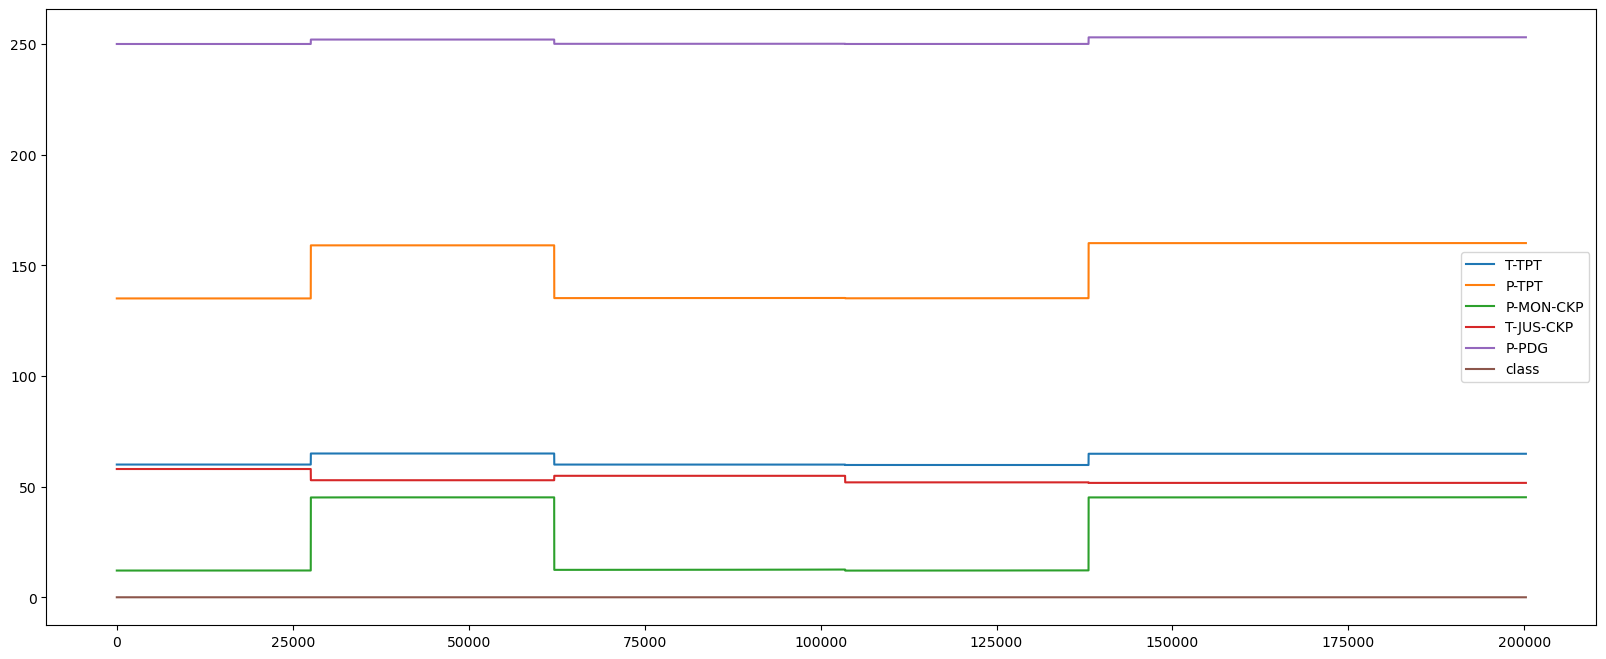

In [14]:
selected_instance_7_df.reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))

In [11]:
filtered_dataset =  "../../filtered_dataset"
filtered_train_dataset =  os.path.join(filtered_dataset, "train")

columns_selected = ['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']

name_file_path = '../../filtered_dataset/name/8.txt' 

# Initialize an empty list to store the lines
instance_8_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    # Read each line and strip any leading/trailing whitespace
    instance_8_list_files = [line.strip() for line in file.readlines()]

selected_instance_8_df = pd.DataFrame(columns=columns_selected)
for instance_file_8 in instance_8_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_8))
    df = df[columns_selected]
    df['class'].fillna(value=0, inplace=True)  # Remove rows where 'class' is NaN
    df = df[df['class'] == 0]
    selected_instance_8_df = pd.concat([selected_instance_8_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in selected_instance_8_df.columns if col.startswith('P')]
selected_instance_8_df[pressure_columns] = selected_instance_8_df[pressure_columns] / 10**6

scaler = StandardScaler()
scaler.fit(selected_instance_8_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-8-filtered.pkl', 'wb'))

selected_instance_8_df = remove_outliers_iqr(selected_instance_8_df)
print(selected_instance_8_df.shape)
# selected_instance_8_df.to_csv("../../filtered_dataset/train/selected_instance_8.csv", index_label='timestamp')

/tmp/ipykernel_53699/1349738458.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_8_df = pd.concat([selected_instance_8_df, df])
/tmp/ipykernel_53699/1349738458.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_8_df = pd.concat([selected_instance_8_df, df])


(61200, 6)


<Axes: >

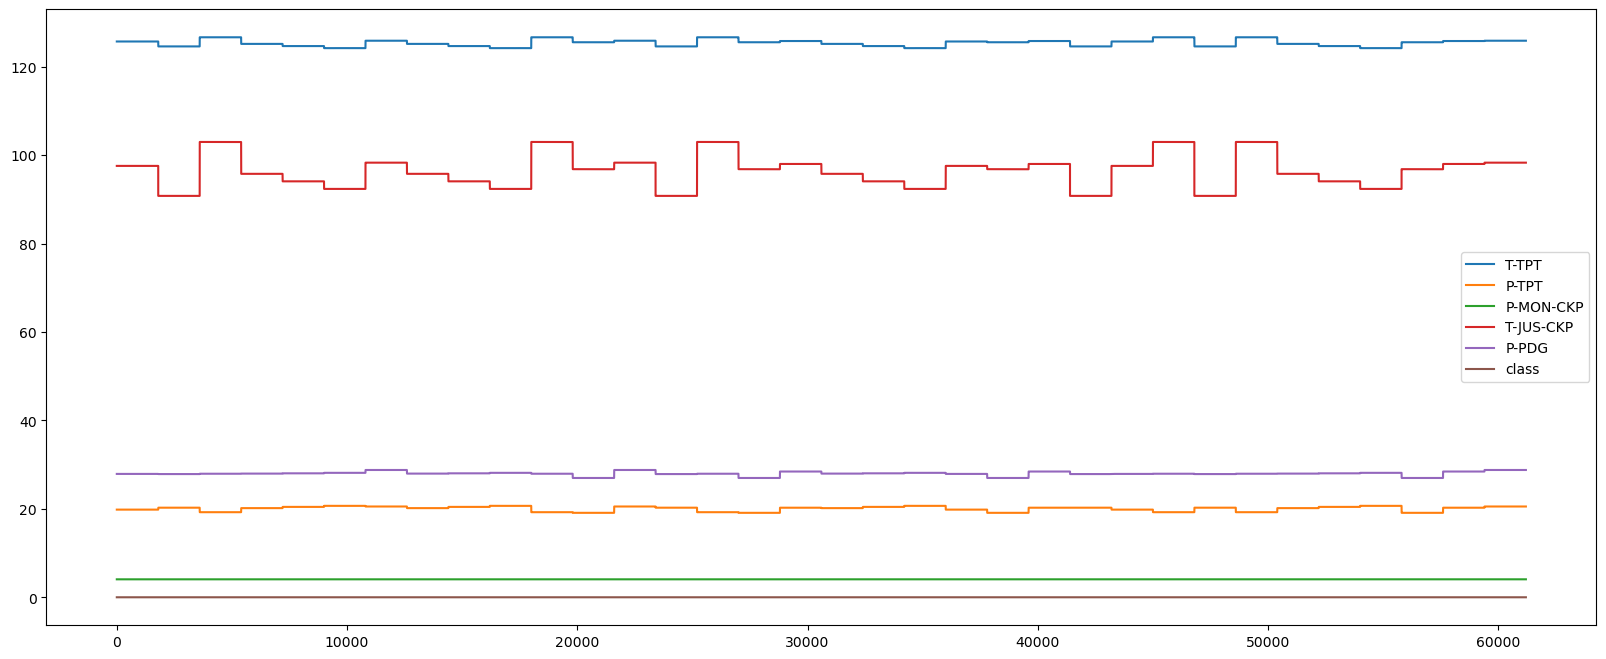

In [6]:
selected_instance_8_df.reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))

In [17]:
filtered_dataset =  "../../filtered_dataset"
filtered_train_dataset =  os.path.join(filtered_dataset, "train")

columns_selected = ['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']

name_file_path = '../../filtered_dataset/name/9.txt' 

# Initialize an empty list to store the lines
instance_9_list_files = []

# Open the file and read its contents
with open(name_file_path, 'r') as file:
    # Read each line and strip any leading/trailing whitespace
    instance_9_list_files = [line.strip() for line in file.readlines()]

selected_instance_9_df = pd.DataFrame(columns=columns_selected)
for instance_file_9 in instance_9_list_files:
    df = pd.read_parquet(os.path.join(dataset_dir, instance_file_9))
    df = df[columns_selected]
    # df['class'].fillna(value=0, inplace=True)  # Remove rows where 'class' is NaN
    df = df[df['class'] == 0]
    selected_instance_9_df = pd.concat([selected_instance_9_df, df])

# Scale pressure columns (those starting with 'P') by 10^6
pressure_columns = [col for col in selected_instance_9_df.columns if col.startswith('P')]
selected_instance_9_df[pressure_columns] = selected_instance_9_df[pressure_columns] / 10**6

scaler = StandardScaler()
scaler.fit(selected_instance_9_df.drop('class', axis=1).values)
pickle.dump(scaler, open('StandardScaler-3W-9-filtered.pkl', 'wb'))

selected_instance_9_df = remove_outliers_iqr(selected_instance_9_df)
selected_instance_9_df.to_csv("../../filtered_dataset/train/selected_instance_9.csv", index_label='timestamp')

/tmp/ipykernel_494340/3663856390.py:22: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  selected_instance_9_df = pd.concat([selected_instance_9_df, df])
/tmp/ipykernel_494340/3663856390.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_instance_9_df = pd.concat([selected_instance_9_df, df])


<Axes: >

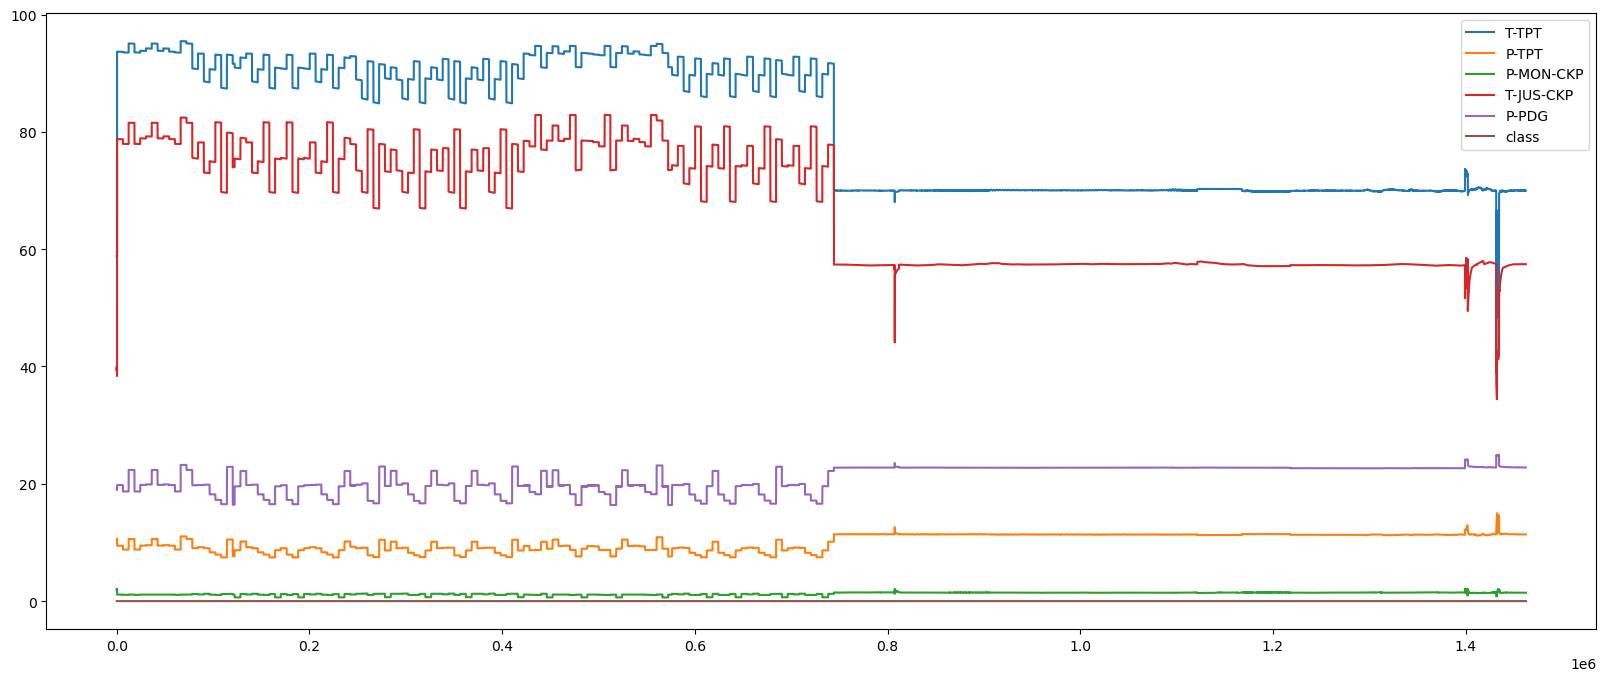

In [18]:
selected_instance_9_df.reset_index()[['T-TPT','P-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-PDG', 'class']].plot(figsize=(20,8))